Setting up R extension



In [ ]:
!pip install rpy2

In [ ]:
%load_ext rpy2.ipython

Direct Sampling Implementation

In [ ]:
%%R
DirectSampl <- function(BgnSt,EndSt,RateM,Tm){
  ptm1 <- proc.time()[1]
  nSt <- nrow(RateM)
  StSp <- 1:nSt
  X <- vector(mode="numeric")
  X[1] <- BgnSt
  T <- vector(mode="numeric")
  T[1] <- 0
  EndTm <- Tm
  Eigen <- eigen(RateM)
  Lam <- Eigen$values
  U <- Eigen$vectors
  InvU <- solve(U)
  PrbM <- U%*%diag(exp(Tm*Lam))%*%InvU
  BgnRate <- -RateM[BgnSt,BgnSt]
  PrbBgnBgn <- PrbM[BgnSt,BgnSt]
  cnt <- 1
  ptm2 <- proc.time()[1]
  while (BgnSt!=EndSt | runif(1)>exp(-BgnRate*Tm)/PrbBgnBgn) {
    if (BgnRate %in% Lam) cat("A j exists such that q_a+lam_j=0","\n")
    PrbBgnEnd <- PrbM[BgnSt,EndSt]
    JVec <- (exp(Tm*Lam)-exp(-Tm*BgnRate))/(Lam+BgnRate)
    PrbV <- (RateM[BgnSt,]/PrbBgnEnd)*
      rowSums(U*matrix(rep(InvU[,EndSt]*JVec,nSt),nrow=nSt,byrow=TRUE))
    NewSt <- sample(StSp[-BgnSt],size=1,prob=pmax(0,PrbV[-BgnSt]))
    CDF.Fct <- function(tm){
      KVec.tm <- exp(Tm*Lam)/(Lam+BgnRate)*(1-exp(-(Lam+BgnRate)*tm))
      CDF.tm <- (RateM[BgnSt,NewSt]/PrbBgnEnd/PrbV[NewSt])*
        sum(U[NewSt,]*InvU[,EndSt]*KVec.tm)
      return(CDF.tm)
    }
    rU <- runif(1)
    RootFct <- function(tm,rU) CDF.Fct(tm)-rU
    uroot <- uniroot(RootFct,interval=c(0,Tm),rU=rU)
    Wt <- uroot$root
    X[cnt+1] <- NewSt
    T[cnt+1] <- T[cnt]+Wt
    cnt <- cnt+1
    Tm <- Tm-Wt
    BgnSt <- NewSt
    PrbM <- U%*%diag(exp(Tm*Lam))%*%InvU
    BgnRate <- -RateM[BgnSt,BgnSt]
    PrbBgnBgn <- PrbM[BgnSt,BgnSt]
  }
  ptm3 <- proc.time()[1]
  Path <- list()
  Path$St <- c(X,EndSt)
  Path$Tm <- c(T,EndTm)
  Path$ptm <- c(ptm2-ptm1,ptm3-ptm2)
  return(Path)
}
JFct <- function(Lam,Tm){
  nSt <- length(Lam)
  JMat <- matrix(0,nSt,nSt)
  expTmLam <- exp(Tm*Lam)
  for (i in 1:nSt){
    for (j in 1:nSt){
      JMat[i,j] <- ifelse(identical(all.equal(Lam[i],Lam[j]),TRUE),
                          Tm*expTmLam[i],
                          (expTmLam[i]-expTmLam[j])/(Lam[i]-Lam[j]))
    }
  }
  return(JMat)
}
cndNsbst <- function(BgnSt,EndSt,RateM,Tm){
  nSt <- nrow(RateM)
  StSp <- 1:nSt
  Eigen <- eigen(RateM)
  Lam <- Eigen$values
  U <- Eigen$vectors
  InvU <- solve(U)
  PrbM <- U%*%diag(exp(Tm*Lam))%*%InvU
  PrbBE <- PrbM[BgnSt,EndSt]
  JMat <- JFct(Lam,Tm)
  N <- 0
  for (i in 1:nSt){
    for (j in StSp[-i]){
      N <- N+RateM[i,j]*
        sum( U[BgnSt,]*InvU[,i]*colSums(U[j,]*InvU[,EndSt]*JMat) )/PrbBE
    }
  }
  return(N)
}
cndNsbstV <- function(BgnSt,EndSt,RateM,TmV){
  len <- length(TmV)
  NV <- rep(0,len)
  for (i in 1:len){
    cat("evaluating no",i,"out of",len,"\n")
    NV[i] <- cndNsbst(BgnSt,EndSt,RateM,TmV[i])
  }
  return(NV)
}

Rejection Sampling Implementation

In [ ]:
%%R
SimpleFrwdSampl <- function(BgnSt,RateM,Tm){
  ptm1 <- proc.time()[1]
  nSt <- nrow(RateM)
  StSp <- 1:nSt
  X <- vector(mode="numeric")
  X[1]<- BgnSt
  T <- vector(mode="numeric")
  T[1] <- 0
  T[2] <- rexp(1,-RateM[X[1],X[1]])
  X[2] <- sample(StSp[-X[1]],1,prob=RateM[X[1],-X[1]])
  cnt <- 2
  ptm2 <- proc.time()[1]
  while (T[cnt] < Tm) {
    T[cnt+1] <- T[cnt]+rexp(1,-RateM[X[cnt],X[cnt]])
    X[cnt+1] <- sample(StSp[-X[cnt]],1,prob=RateM[X[cnt],-X[cnt]])
    cnt <- cnt+1
  }
  ptm3 <- proc.time()[1]
  Path <- list()
  Path$Tm <- c(T[1:(cnt-1)],Tm)
  Path$St <- c(X[1:(cnt-1)],X[cnt-1])
  Path$ptm <- c(ptm2-ptm1,ptm3-ptm2)
  return(Path)
}
ConstrFrwdSampl <- function(BgnSt,RateM,Tm){
  ptm1 <- proc.time()[1]
  nSt <- nrow(RateM)
  StSp <- 1:nSt
  X <- vector(mode="numeric")
  X[1] <- BgnSt
  T <- vector(mode="numeric")
  T[1] <- 0
  RateAwayBgn <- -RateM[BgnSt,BgnSt]
  T[2] <- -log(1-runif(1)*(1-exp(-Tm*RateAwayBgn)))/RateAwayBgn
  X[2] <- sample(StSp[-BgnSt],1,prob=RateM[BgnSt,-BgnSt])
  cnt <- 2
  ptm2 <- proc.time()[1]
  while (T[cnt] < Tm) {
    T[cnt+1] <- T[cnt]+rexp(1,-RateM[X[cnt],X[cnt]])
    X[cnt+1] <- sample(StSp[-X[cnt]],1,prob=RateM[X[cnt],-X[cnt]])
    cnt <- cnt+1
  }
  ptm3 <- proc.time()[1]
  Path <- list()
  Path$Tm <- c(T[1:(cnt-1)],Tm)
  Path$St <- c(X[1:(cnt-1)],X[cnt-1])
  Path$ptm <- c(ptm2-ptm1,ptm3-ptm2)
  return(Path)
}
RejectSampl <- function(BgnSt,EndSt,RateM,Tm){
  if (BgnSt==EndSt){
    p.acc <- AccPrbSame(BgnSt,RateM,Tm)
    if (p.acc < 1e-3) {
      SimPath <- list()
      SimPath$Tm <- c(0,NA,Tm)
      SimPath$St <- c(BgnSt,NA,EndSt)
      SimPath$ptm <- c(NA,NA)
      return(SimPath)
    }
    SimPath <- SimpleFrwdSampl(BgnSt,RateM,Tm)
    ptm <- SimPath$ptm
    while (SimPath$St[length(SimPath$St)]!=EndSt){
      SimPath <- SimpleFrwdSampl(BgnSt,RateM,Tm)
      ptm <- ptm+SimPath$ptm
    }
    SimPath$ptm <- ptm
    return(SimPath)
  }
  if (BgnSt!=EndSt){
    p.acc <- AccPrbDiff(BgnSt,EndSt,RateM,Tm)
    if (p.acc < 1e-3) {
      SimPath <- list()
      SimPath$Tm <- c(0,NA,Tm)
      SimPath$St <- c(BgnSt,NA,EndSt)
      SimPath$ptm <- c(NA,NA)
      return(SimPath)
    }
    SimPath <- ConstrFrwdSampl(BgnSt,RateM,Tm)
    ptm <- SimPath$ptm
    while (SimPath$St[length(SimPath$St)]!=EndSt){
      SimPath <- ConstrFrwdSampl(BgnSt,RateM,Tm)
      ptm <- ptm+SimPath$ptm
    }
    SimPath$ptm <- ptm
    return(SimPath)
  }
}
AccPrbSame <- function(BgnSt,RateM,Tm){
  Eigen <- eigen(RateM)
  Lam <- Eigen$values
  U <- Eigen$vectors
  InvU <- solve(U)
  PrbM <- U%*%diag(exp(Tm*Lam))%*%InvU
  return(PrbM[BgnSt,BgnSt])
}
AccPrbSameV <- function(BgnSt,RateM,TmV){
  len <- length(TmV)
  AccPrbV <- rep(0,len)
  for (i in 1:len) AccPrbV[i] <- AccPrbSame(BgnSt,RateM,TmV[i])
  return(AccPrbV)
}
AccPrbDiff <- function(BgnSt,EndSt,RateM,Tm){
  nSt <- nrow(RateM)
  Eigen <- eigen(RateM)
  Lam <- Eigen$values
  U <- Eigen$vectors
  InvU <- solve(U)
  PrbM <- U%*%diag(exp(Tm*Lam))%*%InvU
  BgnRate <- -RateM[BgnSt,BgnSt]
  PrbBgnBgn <- PrbM[BgnSt,BgnSt]
  if (BgnRate %in% Lam) cat("A j exists such that q_a+lam_j=0","\n")
  JVec <- (exp(Tm*Lam)-exp(-Tm*BgnRate))/(Lam+BgnRate)
  KVec <-
  rowSums(U*matrix(rep(InvU[,EndSt]*JVec,nSt),nrow=nSt,byrow=TRUE))
  AccPrb <- (1/(1-exp(-Tm*BgnRate)))*sum(RateM[BgnSt,-BgnSt]*KVec[-BgnSt])
  return(AccPrb)
}
AccPrbDiffV <- function(BgnSt,EndSt,RateM,TmV){
  len <- length(TmV)
  AccPrbV <- rep(0,len)
  for (i in 1:len) AccPrbV[i] <- AccPrbDiff(BgnSt,EndSt,RateM,TmV[i])
  return(AccPrbV)
}
AccPrbV <- function(BgnSt,EndSt,RateM,TmV){
  if (BgnSt==EndSt) return(AccPrbSameV(BgnSt,RateM,TmV))
  if (BgnSt!=EndSt) return(AccPrbDiffV(BgnSt,EndSt,RateM,TmV))
}
AccPrbAppxV <- function(BgnSt,EndSt,RateM,TmV){
  if (BgnSt!=EndSt){
    nSt <- nrow(RateM)
    StSp <- 1:nSt
    Qa <- -RateM[BgnSt,BgnSt]
    Qab <- RateM[BgnSt,EndSt]
    Qb <- -RateM[EndSt,EndSt]
    nonab <- StSp[-c(BgnSt,EndSt)]
    intcpt <- Qab/Qa
    slope1 <- sum(RateM[BgnSt,nonab]*RateM[nonab,EndSt])/2/Qa
    slope2 <- -Qab*Qb/2/Qa
    return(intcpt+(slope1+slope2)*TmV)
  }
  if (BgnSt==EndSt){
    Qa <- -RateM[BgnSt,BgnSt]
    return(1-Qa*TmV)
  }
}
NsbstSame <- function(BgnSt,RateM,Tm){
  nSt <- nrow(RateM)
  StSp <- 1:nSt
  Eigen <- eigen(RateM)
  Lam <- Eigen$values
  U <- Eigen$vectors
  InvU <- solve(U)
  IVec <- rep(0,nSt)
  for (j in 1:nSt){
    IVec[j] <- ifelse(identical(all.equal(Lam[j],0),TRUE),
                      Tm,
                      (exp(Lam[j]*Tm)-1)/Lam[j])
  }
  TmVec <- rep(0,nSt)
  for (i in 1:nSt){
    TmVec[i] <- sum(U[BgnSt,]*InvU[,i]*IVec)
  }
  N <- 0
  for (i in 1:nSt){
    for (j in StSp[-i]){
      N <- N+RateM[i,j]*TmVec[i]
    }
  }
  return(N)
}
NsbstSameV <- function(BgnSt,RateM,TmV){
  len <- length(TmV)
  NV <- rep(0,len)
  for (i in 1:len) NV[i] <- NsbstSame(BgnSt,RateM,TmV[i])
  return(NV)
}
RejTime <- function(BgnSt,RateM,Tm,NewSt){
  nSt <- nrow(RateM)
  StSp <- 1:nSt
  Eigen <- eigen(RateM)
  Lam <- Eigen$values
  U <- Eigen$vectors
  InvU <- solve(U)
  QBgn <- -RateM[BgnSt,BgnSt]
  TmBgn <- 1/(1-exp(-Tm*QBgn))*
    (-exp(-Tm*QBgn)/QBgn-Tm*exp(-Tm*QBgn)+1/QBgn)
  JVec <- rep(0,nSt)
  for (j in 1:nSt){
    if (all.equal(Lam[j],0)==TRUE){
      JVec[j] <-
        (exp(-Tm*QBgn)/QBgn)*(Tm*exp(Tm*QBgn)-exp(Tm*QBgn)/QBgn+1/QBgn)
      }
    if (all.equal(Lam[j],QBgn)==TRUE){
      JVec[j] <- (1/Lam[j])*(
        (exp(Tm*Lam[j])/QBgn)*(1-exp(-Tm*QBgn))-Tm )
    }
    if (all.equal(Lam[j],0)!=TRUE & all.equal(Lam[j],QBgn)!=TRUE){
      JVec[j] <- (1/Lam[j])*
        (exp(Tm*Lam[j])/QBgn*(1-exp(-Tm*QBgn))-
        (1/(Lam[j]-QBgn))*(exp((Lam[j]-QBgn)*Tm)-1))
    }
  }
  TmInSt <- QBgn/(1-exp(-Tm*QBgn))*colSums(U[NewSt,]*InvU*JVec)
  return(c(TmInSt,TmBgn))
}
NsbstDiff <- function(BgnSt,RateM,Tm){
  nSt <- nrow(RateM)
  StSp <- 1:nSt
  nonBgnSt <- StSp[-BgnSt]
  QBgn <- -RateM[BgnSt,BgnSt]
  TmInSt <- rep(0,nSt+1)
  for (NewSt in nonBgnSt){
    TmInSt <- TmInSt+
      RejTime(BgnSt,RateM,Tm,NewSt)*RateM[BgnSt,NewSt]/QBgn
  }
  nExpSbst <- 1-sum(TmInSt[StSp]*diag(RateM))
  return(nExpSbst)
}
NsbstDiffV <- function(BgnSt,RateM,TmV){
  len <- length(TmV)
  NV <- rep(0,len)
  for (i in 1:len) {
    cat("evaluating no",i,"out of",len,"\n")
    NV[i] <- NsbstDiff(BgnSt,RateM,TmV[i])
  }
  return(NV)
}
NsbstV <- function(BgnSt,EndSt,RateM,TmV){
  if (BgnSt==EndSt) return(NsbstSameV(BgnSt,RateM,TmV))
  if (BgnSt!=EndSt) return(NsbstDiffV(BgnSt,RateM,TmV))
}

Uniform Sampling Implementation

In [ ]:
%%R
UniformSampl <- function(BgnSt,EndSt,RateM,Tm){
  ptm1 <- proc.time()[1]
  Eigen <- eigen(RateM)
  Lam <- Eigen$values
  U <- Eigen$vectors
  InvU <- solve(U)
  PrbBgnEnd <- (U%*%diag(exp(Tm*Lam))%*%InvU)[BgnSt,EndSt]
  nSt <- nrow(RateM)
  Mx <- max(-diag(RateM))
  TransM <- diag(rep(1,times=nSt))+RateM/Mx
  TransMn <- TransM
  rU <- runif(1)
  ifelse(BgnSt==EndSt,cum <- dpois(0,Mx*Tm)/PrbBgnEnd,cum <- 0)
  notExceed <- TRUE
  if (cum>rU) { notExceed <- FALSE }
  nJmp <- 0
  ptm2 <- proc.time()[1]
  while (notExceed){
    nJmp <- nJmp+1
    prb <- dpois(nJmp,Mx*Tm)*TransMn[BgnSt,EndSt]/PrbBgnEnd
    cum <- cum+prb
    if (cum>rU) notExceed <- FALSE
    if (nJmp==1) TransArr <- array(TransM,c(nSt,nSt,1))
    if (nJmp!=1) TransArr <- array(c(TransArr,TransMn),c(nSt,nSt,nJmp))
    TransMn <- TransMn%*%TransM
  }
  ptm3 <- proc.time()[1]
  if (nJmp==0){
    Path <- list()
    Path$St <- c(BgnSt,EndSt)
    Path$Tm <- c(0,Tm)
    Path$ptm <- c(ptm2-ptm1,ptm3-ptm2)
    return(Path)
  }
  if (nJmp==1){
    if (BgnSt==EndSt){
      Path <- list()
      Path$St <- c(BgnSt,EndSt)
      Path$Tm <- c(0,Tm)
      Path$ptm <- c(ptm2-ptm1,ptm3-ptm2)
      return(Path)
    }
    if (BgnSt!=EndSt){
      Path <- list()
      Path$St <- c(BgnSt,EndSt,EndSt)
      Path$Tm <- c(0,Tm*runif(1),Tm)
      Path$ptm <- c(ptm2-ptm1,ptm3-ptm2)
      return(Path)
    }
  }
  JmpTmV <- Tm*sort(runif(nJmp))
  JmpStV <- rep(0,(nJmp-1))
  Prb1 <- TransM[BgnSt,]
  for (i in 1:(nJmp-1)){
    Prb2Mat <- TransArr[,,(nJmp-i)]
    Prb2 <- Prb2Mat[,EndSt]
    JmpStV[i] <-
      sample(1:nSt,size=1,replace=TRUE,round(Prb1*Prb2,digits=10))
    Prb1 <- TransM[JmpStV[i],]
  }
  ptm3 <- proc.time()[1]
  JmpStV <- c(JmpStV,EndSt)
  TrueSub <- c(BgnSt,JmpStV[1:nJmp])!=c(JmpStV[1:nJmp],EndSt)
  Path <- list()
  Path$St <- c(BgnSt,JmpStV[TrueSub],EndSt)
  Path$Tm <- c(    0,JmpTmV[TrueSub],Tm)
  Path$ptm <- c(ptm2-ptm1,ptm3-ptm2)
  return(Path)
}
vNsbst <- function(BgnSt,EndSt,RateM,Tm){
  nSt <- nrow(RateM)
  StSp <- 1:nSt
  Eigen <- eigen(RateM)
  Lam <- Eigen$values
  U <- Eigen$vectors
  InvU <- solve(U)
  PrbM <- U%*%diag(exp(Tm*Lam))%*%InvU
  PrbBE <- PrbM[BgnSt,EndSt]
  Mx <- max(-diag(RateM))
  TransM <- diag(rep(1,times=nSt))+RateM/Mx
  vN <- Mx*Tm*((TransM%*%PrbM)[BgnSt,EndSt])/PrbBE
  return(vN)
}
vNsbstV <- function(BgnSt,EndSt,RateM,TmV){
  len <- length(TmV)
  NV <- rep(0,len)
  for (i in 1:len) NV[i] <- vNsbst(BgnSt,EndSt,RateM,TmV[i])
  return(NV)
}

HKY rate matrix generator

In [ ]:
%%R
HKYRate <- function(kappa,frq){
  SymM <- matrix(c(0,kappa,1,1,
                   kappa,0,1,1,
                   1,1,0,kappa,
                   1,1,kappa,0),
                 nrow=4,ncol=4,byrow=TRUE)
  FrqM <- matrix(rep(frq,4),byrow=TRUE,nrow=4,ncol=4)
  RateM <- SymM*FrqM
  for (i in 1:4) RateM[i,i] <- -sum(RateM[i,-i])
  RateM <- RateM/sum(-diag(RateM)*frq)
  return(RateM)
}

Simulating Figure 1

Beginning state A and ending state A

In [ ]:
%%R
frq <- c(0.2,0.3,0.3,0.2)
RateM <- HKYRate(2,c(0.2,0.3,0.3,0.2))
BgnSt <- 1 ; EndSt <- 1
BgnTm <- 0.01 ; EndTm <- 3 ; nSim <- 30
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 100
par(mfrow=c(3,3))
cat("Rejection sampling","\n")
p.acc <- AccPrbV(BgnSt,EndSt,RateM,TmV)
n.sbst <- NsbstV(BgnSt,EndSt,RateM,TmV)
n.oper <- n.sbst/p.acc
cpu.r.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitR","SmplR")
for (sim in 1:nSim){
  cat(sim)
  cpu.r <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.r <- cpu.r+RejectSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.r.mat[sim,] <- cpu.r
}
cat("\n")
cat("Direct sampling","\n")
cpu.d.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitD","SmplD")
for (sim in 1:nSim){
  cat(sim)
  cpu.d <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.d <- cpu.d+DirectSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.d.mat[sim,] <- cpu.d
}
cat("\n")
cat("Uniformization","\n")
cpu.u.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitU","SmplU")
for (sim in 1:nSim){
  cat(sim)
  cpu.u <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.u <- cpu.u+UniformSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.u.mat[sim,] <- cpu.u
}

Rejection sampling 
123456789101112131415161718192021222324252627282930
Direct sampling 
123456789101112131415161718192021222324252627282930
Uniformization 
123456789101112131415161718192021222324252627282930

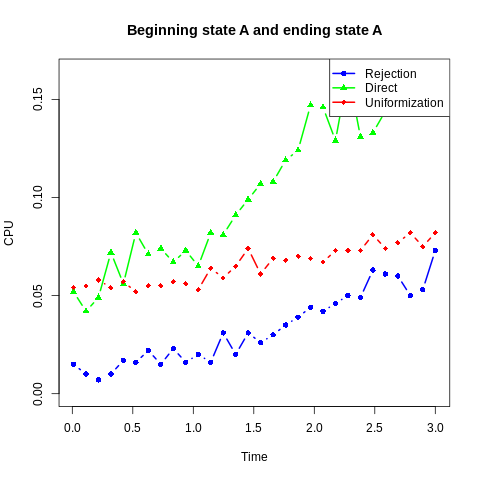

In [ ]:
%%R
colors <- c("blue", "green", "red")
symbols <- c(16, 17, 18)
cpu_rejection <- rowSums(cpu.r.mat)
cpu_direct <- rowSums(cpu.d.mat)
cpu_uniformization <- rowSums(cpu.u.mat)
y_max <- max(cpu_rejection, cpu_direct, cpu_uniformization)
plot(TmV, cpu_rejection, type="b", pch=symbols[1], col=colors[1], lwd=2, ylim=c(0, y_max),
     xlab="Time", ylab="CPU", main="Beginning state A and ending state A")
lines(TmV, cpu_direct, type="b", pch=symbols[2], col=colors[2], lwd=2)
lines(TmV, cpu_uniformization, type="b", pch=symbols[3], col=colors[3], lwd=2)
legend("topright", legend=c("Rejection", "Direct", "Uniformization"),
       col=colors, pch=symbols, lwd=2)

Beginning state A and ending state G

In [ ]:
%%R
frq <- c(0.2,0.3,0.3,0.2)
RateM <- HKYRate(2,c(0.2,0.3,0.3,0.2))
BgnSt <- 1 ; EndSt <- 2
BgnTm <- 0.01 ; EndTm <- 3 ; nSim <- 30
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 100
par(mfrow=c(3,3))
cat("Rejection sampling","\n")
p.acc <- AccPrbV(BgnSt,EndSt,RateM,TmV)
n.sbst <- NsbstV(BgnSt,EndSt,RateM,TmV)
n.oper <- n.sbst/p.acc
cpu.r.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitR","SmplR")
for (sim in 1:nSim){
  cat(sim)
  cpu.r <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.r <- cpu.r+RejectSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.r.mat[sim,] <- cpu.r
}
cat("\n")
cat("Direct sampling","\n")
cpu.d.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitD","SmplD")
for (sim in 1:nSim){
  cat(sim)
  cpu.d <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.d <- cpu.d+DirectSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.d.mat[sim,] <- cpu.d
}
cat("\n")
cat("Uniformization","\n")
cpu.u.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitU","SmplU")
for (sim in 1:nSim){
  cat(sim)
  cpu.u <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.u <- cpu.u+UniformSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.u.mat[sim,] <- cpu.u
}

Rejection sampling 
evaluating no 1 out of 30 
evaluating no 2 out of 30 
evaluating no 3 out of 30 
evaluating no 4 out of 30 
evaluating no 5 out of 30 
evaluating no 6 out of 30 
evaluating no 7 out of 30 
evaluating no 8 out of 30 
evaluating no 9 out of 30 
evaluating no 10 out of 30 
evaluating no 11 out of 30 
evaluating no 12 out of 30 
evaluating no 13 out of 30 
evaluating no 14 out of 30 
evaluating no 15 out of 30 
evaluating no 16 out of 30 
evaluating no 17 out of 30 
evaluating no 18 out of 30 
evaluating no 19 out of 30 
evaluating no 20 out of 30 
evaluating no 21 out of 30 
evaluating no 22 out of 30 
evaluating no 23 out of 30 
evaluating no 24 out of 30 
evaluating no 25 out of 30 
evaluating no 26 out of 30 
evaluating no 27 out of 30 
evaluating no 28 out of 30 
evaluating no 29 out of 30 
evaluating no 30 out of 30 
123456789101112131415161718192021222324252627282930
Direct sampling 
123456789101112131415161718192021222324252627282930
Uniformization 
123456789101

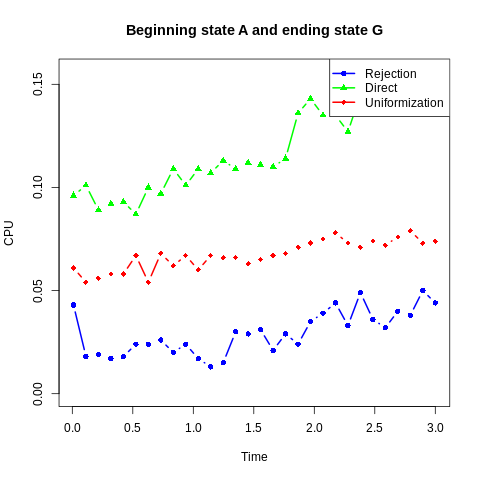

In [ ]:
%%R
colors <- c("blue", "green", "red")
symbols <- c(16, 17, 18)
cpu_rejection <- rowSums(cpu.r.mat)
cpu_direct <- rowSums(cpu.d.mat)
cpu_uniformization <- rowSums(cpu.u.mat)
y_max <- max(cpu_rejection, cpu_direct, cpu_uniformization)
plot(TmV, cpu_rejection, type="b", pch=symbols[1], col=colors[1], lwd=2, ylim=c(0, y_max),
     xlab="Time", ylab="CPU", main="Beginning state A and ending state G")
lines(TmV, cpu_direct, type="b", pch=symbols[2], col=colors[2], lwd=2)
lines(TmV, cpu_uniformization, type="b", pch=symbols[3], col=colors[3], lwd=2)
legend("topright", legend=c("Rejection", "Direct", "Uniformization"),
       col=colors, pch=symbols, lwd=2)

Simulating Figure 4

Beginning state A and ending state A

Rejection sampling 
123456789101112131415161718192021222324252627282930

Rejection sampling complexity: HKY model with beginning state A and ending state A

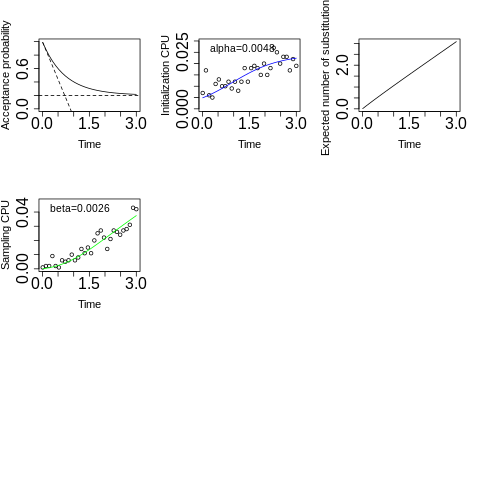

In [ ]:
%%R
frq <- c(0.2,0.3,0.3,0.2)
RateM <- HKYRate(2,c(0.2,0.3,0.3,0.2))
BgnSt <- 1 ; EndSt <- 1
BgnTm <- 0.01 ; EndTm <- 3 ; nSim <- 30
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 100
par(mfrow=c(3,3))
cat("Rejection sampling","\n")
p.acc <- AccPrbV(BgnSt,EndSt,RateM,TmV)
n.sbst <- NsbstV(BgnSt,EndSt,RateM,TmV)
n.oper <- n.sbst/p.acc
cpu.r.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitR","SmplR")
for (sim in 1:nSim){
  cat(sim)
  cpu.r <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.r <- cpu.r+RejectSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.r.mat[sim,] <- cpu.r
}
cat("\n")
cat("\n")
cat("Rejection sampling complexity: HKY model with beginning state A and ending state A")
plot(TmV,p.acc,type="l",ylim=c(0,1),
    xlab="Time",ylab="Acceptance probability",
    cex.axis=2,cex.lab=1.4)
abline(h=frq[EndSt],lty="dashed")
lines(TmV,AccPrbAppxV(BgnSt,EndSt,RateM,TmV),lty="dashed")
plot(TmV,cpu.r.mat[,"InitR"],ylim=1.1*c(0,max(cpu.r.mat[,1])),
     xlab="Time",ylab="Initialization CPU",
     cex.axis=2,cex.lab=1.4)
x1 <- 1/p.acc
alpha1 <- 1/(t(x1)%*%x1)*x1%*%cpu.r.mat[,1]
points(TmV,alpha1*x1,type="l",col="blue")
text(0.1,0.97*max(cpu.r.mat[,1]),pos=4,cex=1.3,
     paste("alpha=",round(alpha1,digits=4),sep=""))
plot(TmV,n.sbst,type="l",ylim=c(0,max(n.sbst)),
    xlab="Time",ylab="Expected number of substitutions",
    cex.axis=2,cex.lab=1.4)
plot(TmV,cpu.r.mat[,2],ylim=1.1*c(0,max(cpu.r.mat[,2])),
     xlab="Time",ylab="Sampling CPU",
     cex.axis=2,cex.lab=1.4)
x2 <- n.oper
alpha2 <- 1/(t(x2)%*%x2)*x2%*%cpu.r.mat[,2]
points(TmV,alpha2*x2,type="l",col="green")
text(0.1,0.97*max(cpu.r.mat[,2]),pos=4,cex=1.3,
     paste("beta=",round(alpha2,digits=4),sep=""))

Beginning state A and ending state G

Rejection sampling 
evaluating no 1 out of 30 
evaluating no 2 out of 30 
evaluating no 3 out of 30 
evaluating no 4 out of 30 
evaluating no 5 out of 30 
evaluating no 6 out of 30 
evaluating no 7 out of 30 
evaluating no 8 out of 30 
evaluating no 9 out of 30 
evaluating no 10 out of 30 
evaluating no 11 out of 30 
evaluating no 12 out of 30 
evaluating no 13 out of 30 
evaluating no 14 out of 30 
evaluating no 15 out of 30 
evaluating no 16 out of 30 
evaluating no 17 out of 30 
evaluating no 18 out of 30 
evaluating no 19 out of 30 
evaluating no 20 out of 30 
evaluating no 21 out of 30 
evaluating no 22 out of 30 
evaluating no 23 out of 30 
evaluating no 24 out of 30 
evaluating no 25 out of 30 
evaluating no 26 out of 30 
evaluating no 27 out of 30 
evaluating no 28 out of 30 
evaluating no 29 out of 30 
evaluating no 30 out of 30 
123456789101112131415161718192021222324252627282930

Rejection sampling complexity: HKY model with beginning state A and ending state G

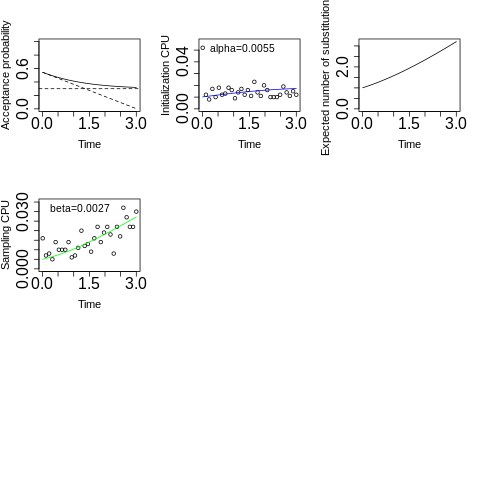

In [ ]:
%%R
frq <- c(0.2,0.3,0.3,0.2)
RateM <- HKYRate(2,c(0.2,0.3,0.3,0.2))
BgnSt <- 1 ; EndSt <- 2
BgnTm <- 0.01 ; EndTm <- 3 ; nSim <- 30
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 100
par(mfrow=c(3,3))
cat("Rejection sampling","\n")
p.acc <- AccPrbV(BgnSt,EndSt,RateM,TmV)
n.sbst <- NsbstV(BgnSt,EndSt,RateM,TmV)
n.oper <- n.sbst/p.acc
cpu.r.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitR","SmplR")
for (sim in 1:nSim){
  cat(sim)
  cpu.r <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.r <- cpu.r+RejectSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.r.mat[sim,] <- cpu.r
}
cat("\n")
cat("\n")
cat("Rejection sampling complexity: HKY model with beginning state A and ending state G")
plot(TmV,p.acc,type="l",ylim=c(0,1),
    xlab="Time",ylab="Acceptance probability",
    cex.axis=2,cex.lab=1.4)
abline(h=frq[EndSt],lty="dashed")
lines(TmV,AccPrbAppxV(BgnSt,EndSt,RateM,TmV),lty="dashed")
plot(TmV,cpu.r.mat[,"InitR"],ylim=1.1*c(0,max(cpu.r.mat[,1])),
     xlab="Time",ylab="Initialization CPU",
     cex.axis=2,cex.lab=1.4)
x1 <- 1/p.acc
alpha1 <- 1/(t(x1)%*%x1)*x1%*%cpu.r.mat[,1]
points(TmV,alpha1*x1,type="l",col="blue")
text(0.1,0.97*max(cpu.r.mat[,1]),pos=4,cex=1.3,
     paste("alpha=",round(alpha1,digits=4),sep=""))
plot(TmV,n.sbst,type="l",ylim=c(0,max(n.sbst)),
    xlab="Time",ylab="Expected number of substitutions",
    cex.axis=2,cex.lab=1.4)
plot(TmV,cpu.r.mat[,2],ylim=1.1*c(0,max(cpu.r.mat[,2])),
     xlab="Time",ylab="Sampling CPU",
     cex.axis=2,cex.lab=1.4)
x2 <- n.oper
alpha2 <- 1/(t(x2)%*%x2)*x2%*%cpu.r.mat[,2]
points(TmV,alpha2*x2,type="l",col="green")
text(0.1,0.97*max(cpu.r.mat[,2]),pos=4,cex=1.3,
     paste("beta=",round(alpha2,digits=4),sep=""))

Simulating Figure 5

Uploading Condon Freq

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving codon.mat to codon.mat


GY rate matrix generator

In [ ]:
%%R
codon.mat <- read.table(file="/content/codon.mat", header=TRUE)
aa <- codon.mat[,"aa"]
codon.freq <- codon.mat[,"frq"]
purine <- c(TRUE,FALSE,TRUE,FALSE)
stop.codon <- rep(FALSE,64)
stop.codon[which(aa=="Stp")] <- TRUE
syn.ts <- matrix(rep(0,64^2),nrow=64,ncol=64)
syn.tv <- matrix(rep(0,64^2),nrow=64,ncol=64)
nonsyn.ts <- matrix(rep(0,64^2),nrow=64,ncol=64)
nonsyn.tv <- matrix(rep(0,64^2),nrow=64,ncol=64)
for (i1 in 1:4){
  for (i2 in 1:4){
    for (i3 in 1:4){
      rw <- (i1-1)*16+(i2-1)*4+i3
      for (j1 in 1:4){
        cl <- (j1-1)*16+(i2-1)*4+i3
        if (j1!=i1){
          ts <- ifelse(purine[i1]==purine[j1],1,0)
          syn <- ifelse(aa[rw]==aa[cl],1,0)
          syn.ts[rw,cl] <- syn*ts
          syn.tv[rw,cl] <- syn*(1-ts)
          nonsyn.ts[rw,cl] <- (1-syn)*ts
          nonsyn.tv[rw,cl] <- (1-syn)*(1-ts)
        }
      }
      for (j2 in 1:4) {
        cl <- (i1-1)*16+(j2-1)*4+i3
        if (j2!=i2){
          ts <- ifelse(purine[i2]==purine[j2],1,0)
          syn <- ifelse(aa[rw]==aa[cl],1,0)
          syn.ts[rw,cl] <- syn*ts
          syn.tv[rw,cl] <- syn*(1-ts)
          nonsyn.ts[rw,cl] <- (1-syn)*ts
          nonsyn.tv[rw,cl] <- (1-syn)*(1-ts)
        }
      }
      for (j3 in 1:4) {
        cl <- (i1-1)*16+(i2-1)*4+j3
        if (j3!=i3){
          ts <- ifelse(purine[i3]==purine[j3],1,0)
          syn <- ifelse(aa[rw]==aa[cl],1,0)
          syn.ts[rw,cl] <- syn*ts
          syn.tv[rw,cl] <- syn*(1-ts)
          nonsyn.ts[rw,cl] <- (1-syn)*ts
          nonsyn.tv[rw,cl] <- (1-syn)*(1-ts)
        }
      }
    }
  }
}
GYRate <- function(kappa,omega,codon.freq){
  GY.r <- kappa*syn.ts+syn.tv+omega*kappa*nonsyn.ts+omega*nonsyn.tv
  GY.r <- GY.r%*%diag(codon.freq)
  GY.r <- GY.r[!stop.codon,!stop.codon]
  if (identical(all.equal(sum(codon.freq[!stop.codon]),1),FALSE)) {
    cat("codon.freq does not add to one","\n")
  }
  scl <- sum(codon.freq[!stop.codon]*GY.r)
  GY.r <- GY.r/scl
  for (i in 1:61) GY.r[i,i] <- -sum(GY.r[i,-i])
  return(GY.r)
}

Acceptance probabilities for rejection sampling: GY model with beginning state AAA and various ending states

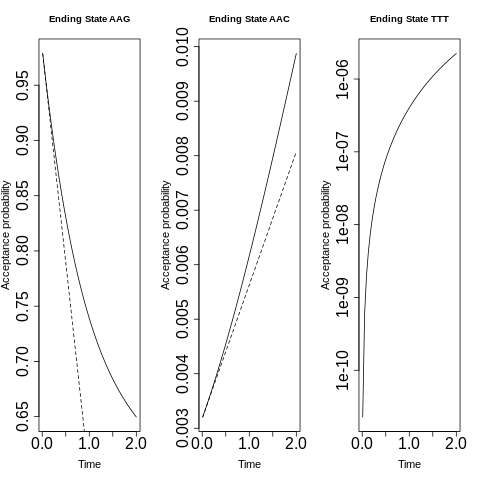

In [ ]:
%%R
par(mfrow=c(1,3))
RateM <- GYRate(2,0.01,codon.freq)
BgnSt <- 1 ; EndSt <- 3
BgnTm <- 0.01 ; EndTm <- 2 ; nSim <- 50
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 250
p.acc <- AccPrbV(BgnSt,EndSt,RateM,TmV)
cat("Acceptance probabilities for rejection sampling: GY model with beginning state AAA and various ending states")
plot(TmV,p.acc,type="l",
     xlab="Time",ylab="Acceptance probability", main="Ending State AAG",
     cex.axis=2,cex.lab=1.4)
lines(TmV,AccPrbAppxV(BgnSt,EndSt,RateM,TmV),lty="dashed")
RateM <- GYRate(2,0.01,codon.freq)
BgnSt <- 1 ; EndSt <- 2
p.acc <- AccPrbV(BgnSt,EndSt,RateM,TmV)
plot(TmV,p.acc,type="l",
     xlab="Time",ylab="Acceptance probability", main="Ending State AAC",
     cex.axis=2,cex.lab=1.4)
lines(TmV,AccPrbAppxV(BgnSt,EndSt,RateM,TmV),lty="dashed")
RateM <- GYRate(2,0.01,codon.freq)
BgnSt <- 1 ; EndSt <- 61
p.acc <- AccPrbV(BgnSt,EndSt,RateM,TmV)
plot(TmV,p.acc,type="l",
     xlab="Time",ylab="Acceptance probability", main="Ending State TTT",
     cex.axis=2,cex.lab=1.4,log="y")

Simulating Figure 6

Beginning state A and ending state A

Direct sampling 
123456789101112131415161718192021222324252627282930
evaluating no 1 out of 30 
evaluating no 2 out of 30 
evaluating no 3 out of 30 
evaluating no 4 out of 30 
evaluating no 5 out of 30 
evaluating no 6 out of 30 
evaluating no 7 out of 30 
evaluating no 8 out of 30 
evaluating no 9 out of 30 
evaluating no 10 out of 30 
evaluating no 11 out of 30 
evaluating no 12 out of 30 
evaluating no 13 out of 30 
evaluating no 14 out of 30 
evaluating no 15 out of 30 
evaluating no 16 out of 30 
evaluating no 17 out of 30 
evaluating no 18 out of 30 
evaluating no 19 out of 30 
evaluating no 20 out of 30 
evaluating no 21 out of 30 
evaluating no 22 out of 30 
evaluating no 23 out of 30 
evaluating no 24 out of 30 
evaluating no 25 out of 30 
evaluating no 26 out of 30 
evaluating no 27 out of 30 
evaluating no 28 out of 30 
evaluating no 29 out of 30 
evaluating no 30 out of 30 

Direct sampling complexity: HKY model with beginning state A and ending state A

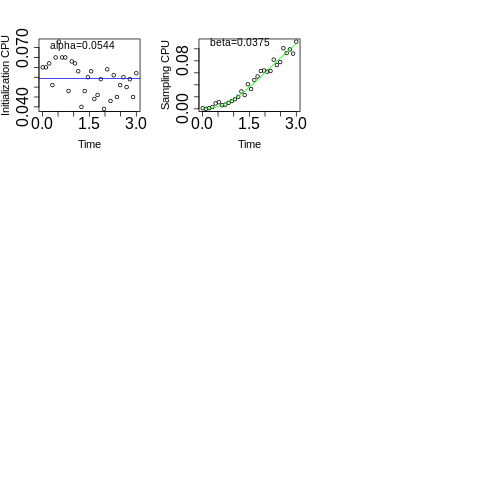

In [ ]:
%%R
frq <- c(0.2,0.3,0.3,0.2)
RateM <- HKYRate(2,c(0.2,0.3,0.3,0.2))
BgnSt <- 1 ; EndSt <- 1
BgnTm <- 0.01 ; EndTm <- 3 ; nSim <- 30
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 100
par(mfrow=c(3,3))
cat("Direct sampling","\n")
cpu.d.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitD","SmplD")
for (sim in 1:nSim){
  cat(sim)
  cpu.d <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.d <- cpu.d+DirectSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.d.mat[sim,] <- cpu.d
}
cat("\n")
n.cnd.sbst <- cndNsbstV(BgnSt,EndSt,RateM,TmV)
cat("\nDirect sampling complexity: HKY model with beginning state A and ending state A")
plot(TmV,cpu.d.mat[,1],xlab="Time",ylab="Initialization CPU",
     cex.axis=2,cex.lab=1.4)
mnInit <- mean(cpu.d.mat[,1])
abline(h=mnInit,col="blue")
text(0.1,0.97*max(cpu.d.mat[,1]),pos=4,cex=1.3,
     paste("alpha=",round(mnInit,digits=4),sep=""))
plot(TmV,cpu.d.mat[,2],ylim=c(0,max(cpu.d.mat)),
     xlab="Time",ylab="Sampling CPU",
     cex.axis=2,cex.lab=1.4)
x <- n.cnd.sbst
alpha <- 1/(t(x)%*%x)*x%*%cpu.d.mat[,2]
points(TmV,alpha*x,type="l",col="green")
text(0.1,0.97*max(cpu.d.mat[,2]),pos=4,cex=1.3,
     paste("beta=",round(alpha,digits=4),sep=""))

Beginning state A and ending state G

Direct sampling 
123456789101112131415161718192021222324252627282930
evaluating no 1 out of 30 
evaluating no 2 out of 30 
evaluating no 3 out of 30 
evaluating no 4 out of 30 
evaluating no 5 out of 30 
evaluating no 6 out of 30 
evaluating no 7 out of 30 
evaluating no 8 out of 30 
evaluating no 9 out of 30 
evaluating no 10 out of 30 
evaluating no 11 out of 30 
evaluating no 12 out of 30 
evaluating no 13 out of 30 
evaluating no 14 out of 30 
evaluating no 15 out of 30 
evaluating no 16 out of 30 
evaluating no 17 out of 30 
evaluating no 18 out of 30 
evaluating no 19 out of 30 
evaluating no 20 out of 30 
evaluating no 21 out of 30 
evaluating no 22 out of 30 
evaluating no 23 out of 30 
evaluating no 24 out of 30 
evaluating no 25 out of 30 
evaluating no 26 out of 30 
evaluating no 27 out of 30 
evaluating no 28 out of 30 
evaluating no 29 out of 30 
evaluating no 30 out of 30 

Direct sampling complexity: HKY model with beginning state A and ending state G

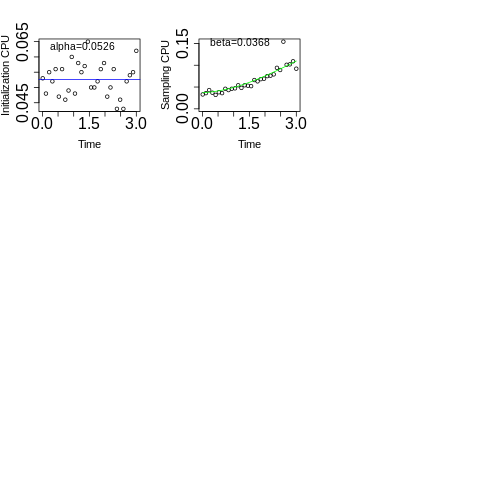

In [ ]:
%%R
frq <- c(0.2,0.3,0.3,0.2)
RateM <- HKYRate(2,c(0.2,0.3,0.3,0.2))
BgnSt <- 1 ; EndSt <- 2
BgnTm <- 0.01 ; EndTm <- 3 ; nSim <- 30
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 100
par(mfrow=c(3,3))
cat("Direct sampling","\n")
cpu.d.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitD","SmplD")
for (sim in 1:nSim){
  cat(sim)
  cpu.d <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.d <- cpu.d+DirectSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.d.mat[sim,] <- cpu.d
}
cat("\n")
n.cnd.sbst <- cndNsbstV(BgnSt,EndSt,RateM,TmV)
cat("\nDirect sampling complexity: HKY model with beginning state A and ending state G")
plot(TmV,cpu.d.mat[,1],xlab="Time",ylab="Initialization CPU",
     cex.axis=2,cex.lab=1.4)
mnInit <- mean(cpu.d.mat[,1])
abline(h=mnInit,col="blue")
text(0.1,0.97*max(cpu.d.mat[,1]),pos=4,cex=1.3,
     paste("alpha=",round(mnInit,digits=4),sep=""))
plot(TmV,cpu.d.mat[,2],ylim=c(0,max(cpu.d.mat)),
     xlab="Time",ylab="Sampling CPU",
     cex.axis=2,cex.lab=1.4)
x <- n.cnd.sbst
alpha <- 1/(t(x)%*%x)*x%*%cpu.d.mat[,2]
points(TmV,alpha*x,type="l",col="green")
text(0.1,0.97*max(cpu.d.mat[,2]),pos=4,cex=1.3,
     paste("beta=",round(alpha,digits=4),sep=""))

Simulating Figure 7

Beginning state A and ending state A

Uniformization 
123456789101112131415161718192021222324252627282930

Uniformization complexity: HKY model with beginning state A and ending state A

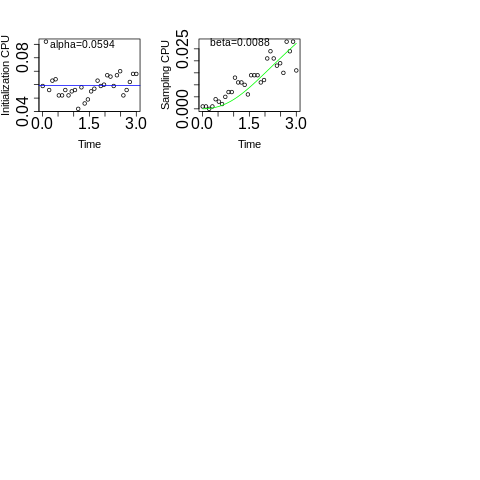

In [ ]:
%%R
frq <- c(0.2,0.3,0.3,0.2)
RateM <- HKYRate(2,c(0.2,0.3,0.3,0.2))
BgnSt <- 1 ; EndSt <- 1
BgnTm <- 0.01 ; EndTm <- 3 ; nSim <- 30
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 100
par(mfrow=c(3,3))
cat("Uniformization","\n")
cpu.u.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitU","SmplU")
for (sim in 1:nSim){
  cat(sim)
  cpu.u <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.u <- cpu.u+UniformSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.u.mat[sim,] <- cpu.u
}
cat("\n")
n.virt.sbst <- vNsbstV(BgnSt,EndSt,RateM,TmV)
cat("\nUniformization complexity: HKY model with beginning state A and ending state A")
plot(TmV,cpu.u.mat[,1],xlab="Time",ylab="Initialization CPU",
     cex.axis=2,cex.lab=1.4)
mnInit <- mean(cpu.u.mat[,1])
abline(h=mnInit,col="blue")
text(0.1,0.97*max(cpu.u.mat[,1]),pos=4,cex=1.3,
     paste("alpha=",round(mnInit,digits=4),sep=""))
plot(TmV,cpu.u.mat[,2],ylim=c(0,max(cpu.u.mat[,2])),
     xlab="Time",ylab="Sampling CPU",
     cex.axis=2,cex.lab=1.4)
x <- n.virt.sbst
alpha <- 1/(t(x)%*%x)*x%*%cpu.u.mat[,2]
points(TmV,alpha*x,type="l",col="green")
text(0.1,0.97*max(cpu.u.mat[,2]),pos=4,cex=1.3,
     paste("beta=",round(alpha,digits=4),sep=""))

Beginning state A and ending state G

Uniformization 
123456789101112131415161718192021222324252627282930

Uniformization complexity: HKY model with beginning state A and ending state G

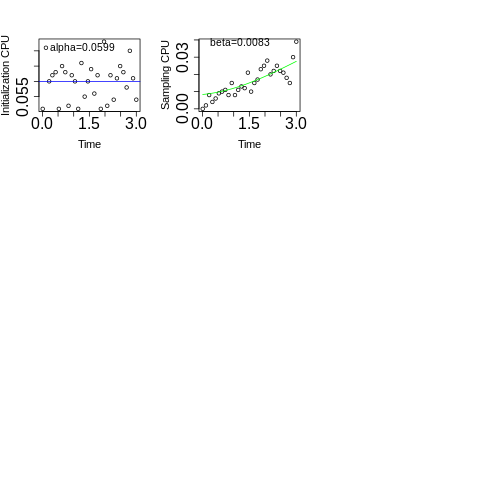

In [ ]:
%%R
frq <- c(0.2,0.3,0.3,0.2)
RateM <- HKYRate(2,c(0.2,0.3,0.3,0.2))
BgnSt <- 1 ; EndSt <- 2
BgnTm <- 0.01 ; EndTm <- 3 ; nSim <- 30
TmV <- seq(BgnTm,EndTm,len=nSim)
nSmpl <- 100
par(mfrow=c(3,3))
cat("Uniformization","\n")
cpu.u.mat <- matrix(0,nrow=nSim,ncol=2)
colnames(cpu.r.mat) <- c("InitU","SmplU")
for (sim in 1:nSim){
  cat(sim)
  cpu.u <- c(0,0)
  for (smpl in 1:nSmpl){
    cpu.u <- cpu.u+UniformSampl(BgnSt,EndSt,RateM,TmV[sim])$ptm
  }
  cpu.u.mat[sim,] <- cpu.u
}
cat("\n")
n.virt.sbst <- vNsbstV(BgnSt,EndSt,RateM,TmV)
cat("\nUniformization complexity: HKY model with beginning state A and ending state G")
plot(TmV,cpu.u.mat[,1],xlab="Time",ylab="Initialization CPU",
     cex.axis=2,cex.lab=1.4)
mnInit <- mean(cpu.u.mat[,1])
abline(h=mnInit,col="blue")
text(0.1,0.97*max(cpu.u.mat[,1]),pos=4,cex=1.3,
     paste("alpha=",round(mnInit,digits=4),sep=""))
plot(TmV,cpu.u.mat[,2],ylim=c(0,max(cpu.u.mat[,2])),
     xlab="Time",ylab="Sampling CPU",
     cex.axis=2,cex.lab=1.4)
x <- n.virt.sbst
alpha <- 1/(t(x)%*%x)*x%*%cpu.u.mat[,2]
points(TmV,alpha*x,type="l",col="green")
text(0.1,0.97*max(cpu.u.mat[,2]),pos=4,cex=1.3,
     paste("beta=",round(alpha,digits=4),sep=""))